# Training a classifier
We will train a classier for the dataset CIFAR10 that contains images belonging to 10 different classes in two ways:
- training a CNN from scratch
- finetuning a CNN

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# define transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# define batch size
batch_size = 4

# load train ds
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# load test ds
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


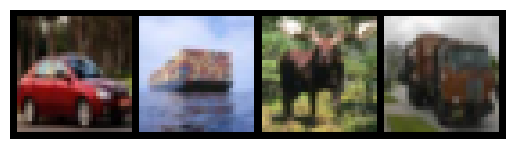

car ship deer truck


In [3]:
# show some images
import matplotlib.pyplot as plt

def denorm(x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

to_pil = transforms.ToPILImage()

img, labels = next(iter(trainloader))

plt.imshow(to_pil(torchvision.utils.make_grid(denorm(img))))
plt.axis("off")
plt.show()

# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Define a CNN to classify the images
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolutional block
        self.conv_block1 = nn.Sequential(nn.Conv2d(3, 6, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2))
        # second convolutional block
        self.conv_block2 = nn.Sequential(nn.Conv2d(6, 16, kernel_size=5),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2, 2))
        # fully connected blocks
        self.fc1 = nn.Sequential(nn.Linear(16 * 5 * 5, 120),
                                nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # FEATURE EXTRACTOR
        x = self.conv_block1(x)
        x = self.conv_block2(x) # bs,16,5,5
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = x.view(x.size(0), -1)

        # CLASSIFICATION HEAD
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x # B, 10


net = Net().to(device)
print(net)

Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
# define Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# TRAIN!
# put net into train mode
net.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.184
[1,  4000] loss: 1.862
[1,  6000] loss: 1.656
[1,  8000] loss: 1.580
[1, 10000] loss: 1.522
[1, 12000] loss: 1.506
[2,  2000] loss: 1.415
[2,  4000] loss: 1.392
[2,  6000] loss: 1.338
[2,  8000] loss: 1.327
[2, 10000] loss: 1.303
[2, 12000] loss: 1.310
Finished Training


In [8]:
# if you want to save the model
PATH = './res/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [9]:
# if you want to load the model
PATH = './res/cifar_net.pth'
net.load_state_dict(torch.load(PATH))

C:\Users\Tomaso Fontanini\AppData\Local\Temp\ipykernel_6884\502442806.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

# Evaluate the model
## Evaluation Mode (<code>nn.Module.eval()</code>)
Evaluation mode is not actually a mechanism to locally disable gradient computation, but it is sometimes confused to be such a mechanism.

Functionally, <code>module.eval()</code> (or equivalently <code>module.train(False)</code>) are completely orthogonal to no-grad mode and inference mode. How <code>model.eval()</code> affects your model depends entirely on the specific modules used in your model and whether they define any training-mode specific behavior.

You are responsible for calling <code>model.eval()</code> and <code>model.train()</code> if your model relies on modules such as <code>torch.nn.Dropout</code> and <code>torch.nn.BatchNorm2d</code> that may behave differently depending on training mode, for example, to avoid updating your BatchNorm running statistics on validation data.

It is recommended that you always use <code>model.train()</code> when training and <code>model.eval()</code> when evaluating your model (validation/testing) even if you aren’t sure your model has training-mode specific behavior, because a module you are using might be updated to behave differently in training and eval modes.

## No-grad Mode
Computations in no-grad mode behave as if none of the inputs require grad. In other words, computations in no-grad mode are never recorded in the backward graph even if there are inputs that have <code>require_grad=True</code>.

Enable no-grad mode when you need to perform operations that should not be recorded by autograd, but you’d still like to use the outputs of these computations in grad mode later. This context manager makes it convenient to disable gradients for a block of code or function without having to temporarily set tensors to have <code>requires_grad=False</code>, and then back to <code>True</code>.

In [10]:
# now lets evaluate the model on the test set
correct = 0
total = 0

# put net into evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # put data on correct device
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
net.train()

Accuracy of the network on the 10000 test images: 54 %


Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Ex1: try to get the accuracy for each class

The classifier was able to correctly classify CIFAR10 with a good accuracy, but we can do much better!
HOW?